In [1]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive')
dep_path = os.getcwd()+'/drive/My Drive/datasets/'
sys.path.insert(0, dep_path)
os.listdir(dep_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['GoogleNews-vectors-negative300.bin.gz',
 'cifar-10-batches-py',
 'mnist',
 'fashion',
 'Digital_Music_5.json',
 'News_Category_Dataset_v2.json',
 'large_imbd',
 'Consumer_Complaints.csv',
 'clustering',
 'load_mnist.py',
 '__pycache__',
 'aclImdb_v1.tar.gz',
 'load_cifar.py',
 'load_mnist.py.gdoc',
 'load_cifar.py.gdoc']

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import load_cifar


In [0]:
data = dict()
data = load_cifar.load_data(dep_path+'cifar-10-batches-py/')

### Dataset Labels

In [0]:
labels=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
DIM = 32
CH = 3

Label: frog


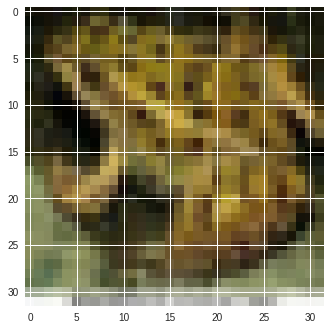

In [5]:
x = np.random.randint(50000)
print('Label: {}'.format(labels[data['train_y'][x]]))
plt.imshow(data['train_x'][x].reshape(DIM,DIM,CH))

### Data Preprocessing

#### 1. Hot-Encode

In [6]:
n_classes = 10
id_mtx = np.identity(n_classes,dtype=np.float32)
data['train_y'] = id_mtx[data['train_y']]
data['test_y'] = id_mtx[data['test_y']]
data['train_y'].shape, data['test_y'].shape

((50000, 10), (10000, 10))

#### 2. Normalize

In [0]:
data['train_x'] = data['train_x'].astype(np.float32)/255
data['test_x'] = data['test_x'].astype(np.float32)/255

### Hyper-Parameters

In [0]:
log_dir = "/content/logs"
writer = tf.summary.FileWriter(log_dir)

In [0]:
batch_size = 64
epochs = 10
probability_drop = 0.6

#learning rate
start_lr = 1e-3
end_lr = 5e-3
decay_steps = 10000
#lr = tf.train.exponential_decay(start_lr,global_step, decay_steps, 0.96, staircase=True)
lr = 0.001

In [10]:
data['test_x'][:1000,:,:,:].shape

(1000, 32, 32, 3)

### Dataset Pipeline

In [11]:
with tf.variable_scope("dataset_gen" ):    
    dtrain_x = tf.data.Dataset.from_tensor_slices(data['train_x'])
    dtrain_y = tf.data.Dataset.from_tensor_slices(data['train_y'])
    dtrain = tf.data.Dataset.zip(( dtrain_x, dtrain_y )).batch(batch_size)
    
    dtest_x = tf.data.Dataset.from_tensor_slices(data['test_x'])
    dtest_y = tf.data.Dataset.from_tensor_slices(data['test_y'])
    dtest = tf.data.Dataset.zip(( dtest_x,dtest_y )).batch(batch_size)
    
    dvalid_x = tf.data.Dataset.from_tensor_slices(data['test_x'][:1000,:,:,:])
    dvalid_y = tf.data.Dataset.from_tensor_slices(data['test_y'][:1000])
    dvalid = tf.data.Dataset.zip(( dvalid_x,dvalid_y )).batch(batch_size)
(dtrain,dtest,dvalid)

(<DatasetV1Adapter shapes: ((?, 32, 32, 3), (?, 10)), types: (tf.float32, tf.float32)>,
 <DatasetV1Adapter shapes: ((?, 32, 32, 3), (?, 10)), types: (tf.float32, tf.float32)>,
 <DatasetV1Adapter shapes: ((?, 32, 32, 3), (?, 10)), types: (tf.float32, tf.float32)>)

In [12]:
#print(dtrain.output_types,dtrain.output_shapes)
#iterator 
iterator = tf.data.Iterator.from_structure(dtrain.output_types,dtrain.output_shapes)
get_batch = iterator.get_next()
#for train
dtrain_init = iterator.make_initializer(dtrain)
#for test
dtest_init = iterator.make_initializer(dtest)
#for validation
dvalid_init = iterator.make_initializer(dvalid)

Instructions for updating:
Colocations handled automatically by placer.


### Model Class

In [0]:
class CNN:
    def total_params(self):
        count = 0
        info = ""
        for var in tf.trainable_variables():
            shape = var.get_shape()
            p = 1
            info = info + "varname : "+var.name+"-("
            print("varname : " + var.name,end=' ')
            l = []
            for d in shape:
                p*=d
                info = info + " " + str(d)
                l.append(d)
            count+=p
            print(l)
            info = info+" )$"
        info = info + "total param count : "+str(count)
        print("total number of trainable parameter : {}".format(count))
        return info

    def create_conv_layer(self, inp, filters, stride, padding):
        wt =  tf.get_variable(name='weight', shape = filters)
        conv = tf.nn.conv2d(input = inp, filter = wt, strides = stride, padding = padding)
        b = tf.get_variable(name='bias', initializer = tf.zeros(shape=[filters[-1]]))
        out = tf.add(conv, b)
        return out
      
    def hidden_layer(self,units,prev):
        #print([int(prev.shape[-1]),units])
        wt =  tf.get_variable(name='weight', shape=[int(prev.shape[-1]),units])
        b = tf.get_variable(name='bias', initializer = tf.zeros(shape=[units]))
        #print(prev.shape,wt.shape,b.shape)
        out=tf.matmul(prev,wt)
        return tf.add(out,b)

    def cnn(self, data, is_train, prob_drop):
        l1 = [5,5,3,32]
        with tf.variable_scope("conv_1", reuse=tf.AUTO_REUSE):
            conv1 = self.create_conv_layer(data, l1, [1]*4, "SAME")
            #conv1 = tf.layers.batch_normalization(conv1, training = is_train)
            conv1 = tf.nn.relu(conv1)
            conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides = [1,2,2,1], padding = "SAME")
            #conv1 = tf.nn.dropout(conv1, rate = prob_drop)
        l2 = [5,5,l1[-1],64]
        with tf.variable_scope("conv_2", reuse=tf.AUTO_REUSE):
            conv2 = self.create_conv_layer(conv1, l2, [1]*4, "SAME")
            #conv2 = tf.layers.batch_normalization(conv2, training = is_train)
            conv2 = tf.nn.relu(conv2)
            conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides = [1,2,2,1], padding = "SAME")
            #conv2 = tf.nn.dropout(conv2, rate = prob_drop)
        """
        l3 = [3,3,l2[-1],128]
        with tf.variable_scope("conv_3", reuse=tf.AUTO_REUSE):
            conv3 = self.create_conv_layer(conv2, l3, [1]*4, "SAME")
            #conv3 = tf.layers.batch_normalization(conv3, training = is_train)
            conv3 = tf.nn.relu(conv3)
            conv3 = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides = [1,2,2,1], padding = "SAME")
            #conv3 = tf.nn.dropout(conv3, rate = prob_drop)
        
        l4 = [3,3,l3[-1],256]
        with tf.variable_scope("conv_4", reuse=tf.AUTO_REUSE):
            conv4 = self.create_conv_layer(conv3, l4, [1]*4, "SAME")
            conv4 = tf.layers.batch_normalization(conv4, training = is_train)
            conv4 = tf.nn.relu(conv4)
            conv4 = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides = [1,2,2,1], padding = "SAME")
            conv4 = tf.nn.dropout(conv4, rate = prob_drop)
        """
        flat = tf.reshape(conv2,[-1,np.prod(conv2.shape[1:])])
        #print(conv1.shape,conv2.shape,flat.shape)
        
        with tf.variable_scope("hidden_1", reuse = tf.AUTO_REUSE):
            h1 = self.hidden_layer(1024,flat)
            h1 = tf.nn.relu(h1)
            h1 = tf.nn.dropout(h1, rate = prob_drop)
            
        with tf.variable_scope("output",reuse = tf.AUTO_REUSE):
            y = self.hidden_layer(10,h1)
            #y = tf.nn.sigmoid(y)
        #y = tf.layers.batch_normalization(inputs = y, training = is_train)
        return y

    def __init__(self, data, is_train, prob_drop):
        tf.set_random_seed(1997)
        self.logits = self.cnn(data, is_train, prob_drop)

### Model Declaration

In [14]:
is_train = tf.placeholder(shape=(),dtype=tf.bool,name='is_train')
prob_drop = tf.placeholder(shape=(),dtype=tf.float32,name = 'probability_drop')
global_step = tf.Variable(0, trainable=False)
current_model = CNN(get_batch[0], is_train, prob_drop)
param_info = current_model.total_params()

varname : conv_1/weight:0 [Dimension(5), Dimension(5), Dimension(3), Dimension(32)]
varname : conv_1/bias:0 [Dimension(32)]
varname : conv_2/weight:0 [Dimension(5), Dimension(5), Dimension(32), Dimension(64)]
varname : conv_2/bias:0 [Dimension(64)]
varname : hidden_1/weight:0 [Dimension(4096), Dimension(1024)]
varname : hidden_1/bias:0 [Dimension(1024)]
varname : output/weight:0 [Dimension(1024), Dimension(10)]
varname : output/bias:0 [Dimension(10)]
total number of trainable parameter : 4259274


### Optimization

In [0]:
logits = current_model.logits
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=get_batch[1],logits=logits))
tf.summary.scalar("losses",loss)
tf.summary.scalar("learning_rate",lr)
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    optimizer = tf.train.AdamOptimizer(lr).minimize(loss, global_step=global_step)


In [0]:
predictions = tf.argmax(logits,axis=1)
labels = tf.argmax(get_batch[1],axis=1)
equality = tf.equal(predictions,labels)
accuracy = tf.reduce_mean(tf.cast(equality,tf.float32))
#conf_mtx=tf.confusion_matrix(labels=tf.argmax(get_batch[1],axis=1),predictions=tf.argmax(logits,axis=1),num_classes=n_classes)
tf.summary.scalar("accuracy",accuracy)
#tf.summary.text("confusion_matrix", tf.cast(conf_mtx,tf.string))
ginit_op = tf.global_variables_initializer()
t_summary = tf.summary.merge_all()

In [0]:
def run_dataset(sess, init_op, variables, feed_dict, train=False):
    sess.run(init_op)
    logs = []
    itr = 0
    #stack = np.random.rand(1,n_classes)
    #stack = []
    stack = np.zeros((10,10),dtype=np.int32)
    while True:
        try:
            itr+=1
            res = sess.run(variables, feed_dict=feed_dict)
            #logs.append(res[0]) # first element of the result is either accuracy or loss
            if train:           # for train variables = [loss, opt, acc, t_summary]
                logs.append(res[2])
                writer.add_summary(res[-1],i)
                if itr%100 == 0:
                    print("batch :{}, loss :{:.3f}, accuracy :{:.3f}".format(itr,res[0],res[2]))
            else:               # for not train variables = [acc, conf_mtx]
                #print("{} - res = {}".format(itr,res))
                logs.append(res[0])
                #stack = np.vstack((stack,res[-1]))
                #stack.append(res[-1])
                stack = stack + res[-1]
        except tf.errors.OutOfRangeError:
            return logs,stack

LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(log_dir)
)
# Install
#! npm install -g localtunnel

# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

# Get url
! cat url.txt


LOG_DIR = '/tmp/log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 --debugger_port 6006 &'
    .format(log_dir)
)
print("tensorboard initialized...")
"""
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1
! unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1"""
get_ipython().system_raw('./ngrok http 6006 &')
print("tunneled to outside...")
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [18]:
import time
valid_log_acc = []
train_log_acc=[]
test_acc=[]
train_acc=[]
with tf.Session() as sess:
    writer.add_graph(sess.graph)
    sess.run(ginit_op)
    train_log_loss = []
    valid_log_loss = []
    total_train_time = 0
    for i in range(1,epochs+1):
        print("training epoch : {}".format(i))
        #sess.run(dtrain_init) #initialized the the train pipeline
        feed_dict={is_train:True,prob_drop:probability_drop} # training parameters
        variables = [loss,optimizer,accuracy,t_summary] # output variables 
        train_start_time = time.time()
        acc,_  = run_dataset(sess, dtrain_init, variables, feed_dict, True)
        total_train_time = total_train_time + time.time() - train_start_time
        acc = np.array(acc)
        train_log_acc.append(acc.mean())
        print("approx. train accuracy : {:.4f} ".format(acc.mean()))
        variables = [accuracy]
        feed_dict = {is_train:False,prob_drop:0}
        acc,_ = run_dataset(sess, dvalid_init, variables, feed_dict)
        acc = np.array(acc)
        valid_log_acc.append(acc.mean())
        print("average validation accuracy :{:.4f}".format(acc.mean()))
    
    #for test dataset
    variables = [accuracy]
    feed_dict = {is_train:False,prob_drop:0}
    acc, test_stack = run_dataset(sess, dtest_init, variables, feed_dict)
    test_acc = np.array(acc)
    print("average test accuracy :{:.4f}".format(test_acc.mean()))
    
    print("total training time = {:}".format(total_train_time))
    # for train dataset
    variables = [accuracy]
    feed_dict = {is_train:False,prob_drop:0.0}
    acc, train_stack = run_dataset(sess, dtrain_init, variables, feed_dict)
    train_acc = np.array(acc)
    print("average train accuracy :{:.4f}".format(train_acc.mean()))
    

training epoch : 1
batch :100, loss :1.704, accuracy :0.375
batch :200, loss :1.649, accuracy :0.469
batch :300, loss :1.620, accuracy :0.453
batch :400, loss :1.252, accuracy :0.625
batch :500, loss :1.251, accuracy :0.500
batch :600, loss :1.367, accuracy :0.562
batch :700, loss :1.339, accuracy :0.531
approx. train accuracy : 0.4475 
average validation accuracy :0.5898
training epoch : 2
batch :100, loss :1.059, accuracy :0.672
batch :200, loss :1.115, accuracy :0.625
batch :300, loss :1.290, accuracy :0.578
batch :400, loss :0.955, accuracy :0.719
batch :500, loss :0.919, accuracy :0.750
batch :600, loss :1.081, accuracy :0.609
batch :700, loss :1.169, accuracy :0.609
approx. train accuracy : 0.5939 
average validation accuracy :0.6533
training epoch : 3
batch :100, loss :0.816, accuracy :0.766
batch :200, loss :1.050, accuracy :0.641
batch :300, loss :1.138, accuracy :0.547
batch :400, loss :0.905, accuracy :0.734
batch :500, loss :0.941, accuracy :0.734
batch :600, loss :0.963, a

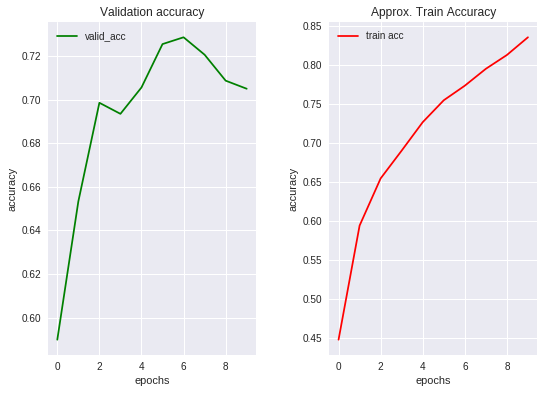

<Figure size 576x396 with 0 Axes>

In [19]:
fig1 = plt.gcf()
plt.subplot(121)
plt.plot(valid_log_acc,label='valid_acc',color='g')
train_log_loss = np.array(train_log_loss).reshape(-1)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Validation accuracy')
plt.legend()
plt.subplot(122)
plt.plot(train_log_acc,label='train acc', color='r')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Approx. Train Accuracy')  
plt.legend()
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()
name = os.getcwd()+"/drive/My Drive/outputs/"
plt.draw()
fig1.savefig(name+"output.png", dpi=300,bbox_inches="tight")

In [0]:
file_save = dict()
file_save['batch_size'] = batch_size
file_save['epochs'] = epochs
file_save['Prob_drop'] = probability_drop
file_save['train'] = train_log_acc
file_save['valid'] = valid_log_acc
file_save['avg_train'] = train_acc
file_save['avg_test'] = test_acc
file_save['train_time'] = total_train_time
np.save(name+'output.npy', file_save)

In [21]:
print(file_save)

{'batch_size': 64, 'epochs': 10, 'Prob_drop': 0.6, 'train': [0.44745046, 0.59386986, 0.65439177, 0.6900975, 0.7265625, 0.7546755, 0.77337754, 0.7950368, 0.81275976, 0.83547795], 'valid': [0.58984375, 0.6533203, 0.69863284, 0.6935547, 0.70566404, 0.72558594, 0.72871095, 0.7207031, 0.70878905, 0.7050781]}
